In [22]:
import sys
print(sys.path)
sys.path.append("./")
print(sys.path)

['', '/home/apospiech/Programme/anaconda3/lib/python35.zip', '/home/apospiech/Programme/anaconda3/lib/python3.5', '/home/apospiech/Programme/anaconda3/lib/python3.5/plat-linux', '/home/apospiech/Programme/anaconda3/lib/python3.5/lib-dynload', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/Sphinx-1.4.6-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/json_delta-2.0-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/thrift-0.9.3-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/thrift_sasl-0.2.1-py3.5.egg', '/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/IPython/extensions', '/home/apospiech/.ipython']
['', '/home/apospiech/Programme/anaconda3/lib/python35.zip', '/home/apospiech/Programme/anaconda3/lib/python3.5', 

In [8]:
import matplotlib.pyplot as plt

In [3]:
def sum_of_squares(v):
    return sum(v_i ** 2 for v_i in v)

def square(x):
    return x*x

def derivative_of_square(x):
    return 2*x

In [4]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

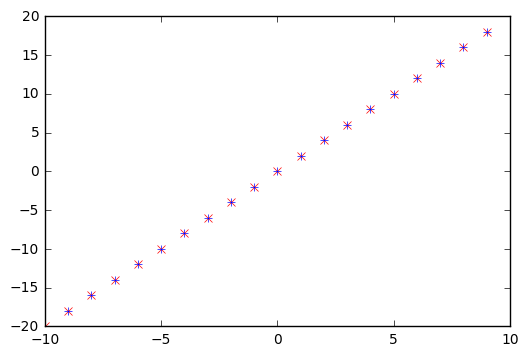

In [14]:
from functools import partial

derivative_estimate = partial(difference_quotient, square, h=0.00001)

x = range(-10, 10)
plt.plot(x, list(map(derivative_of_square, x)), 'rx', label='Actual')
plt.plot(x, list(map(derivative_estimate, x)), 'b+', label='Estimate')
plt.show()

In [18]:
def partial_difference_quotient(f, v, i, h):
    w = [v_j + (h if j == i else 0) for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h) for i, _ in enumerate(v)]

In [51]:
def step(v, direction, step_size):
    print("step", v, direction, step_size)
    print([v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)])
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

In [34]:
import random
from lib.lin_alg_vectors import *

v = [random.randint(-10, 10) for i in range(3)]
print(v)

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v)
    next_v = step(v, gradient, -0.01)
    if distance(next_v, v) < tolerance:
        break
    v = next_v
    
print([round(v_i, 5) for v_i in v])

[-7, -5, -10]
[-0.0, -0.0, -0.0]


In [35]:
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

In [36]:
def safe(f):
    def safe_f(*arg, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

In [49]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    
    i = 0
    
    while i < 10:
        gradient = gradient_fn(theta)
        print("before", theta, gradient)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        
        next_theta = min(next_thetas, key=target_fn)        
        next_value = target_fn(next_theta)
        print("after", next_theta, next_value)
        
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value
        i += 1

In [2]:
def negate(func):
    return lambda *args, **kwargs: -func(*args, **kwargs)

def negate_all(func):
    return lambda *args, **kwargs: [-y for y in func(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                         negate_all(gradient_fn),
                         theta_0,
                         tolerance)

In [54]:
def in_random_order(data):
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]

In [55]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x,y)
    theta = theta_0
    alpha = alpha_0
    min_theta = None
    min_value = float("inf")
    iterations_with_no_improvement = 0
    
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)
        
        if value < min_value:
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta

In [3]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(
        negate(target_fn), 
        negate_all(gradient_fn),
        x,
        y,
        theta_0,
        alpha_0
    )